# Churn model - Training a simple classification model

## Get the data
We will use a learning purposes dataset created with simulated data. This dataset can be found [here](https://raw.githubusercontent.com/lfbraz/azure-databricks-mlops/master/dataset/dados_clientes.csv). We will download this dataset to `dbfs` to be able to import data to dataframes.

In [4]:
from azureml.core import Workspace, Dataset

workspace = Workspace.from_config()

dataset = Dataset.get_by_name(workspace, name='Clientes')
customer_data = dataset.to_pandas_dataframe()

We will develop a `sklearn` model so it will be easier to work with a Pandas Dataframe instead of a spark one (of course, when we are working in an spark environment it would be better to work with spark dataframes because of performance aspects, however for this tutorial we will use Pandas for learning reasons)

In [5]:
customer_data.head(5)

,CodigoCliente,Titulo,PrimeiroNome,UltimoNome,Idade,Sexo,Endereco,Cidade,UF,UFCompleto,...,AnosDeRelacionamentoBanco,JaUsouChequeEspecial,QtdEmprestimos,NumeroAtendimentos,TMA,IndiceSatisfacao,Saldo,CLTV,CanalPref,Churn
0,1.0,Sra.,Fernanda,Camargo,32.0,Feminino,"Rua Paulo Suplicy, 376",São Paulo,SP,São Paulo,...,3.0,0.0,1.0,7.0,2.0,4.0,55229.0,65.0,Push,0.0
1,2.0,Sr.,Paulo,Dias,63.0,Masculino,Estrada Transcastanhal 456,Castanhal,PA,Pará,...,2.0,1.0,0.0,15.0,87.0,3.0,9936.0,66.0,Email,1.0
2,3.0,Sr.,Enzo,Araujo,64.0,Masculino,Rua Joana D'Arc Gonçalves 576,Araxá,MG,Minas Gerais,...,19.0,0.0,0.0,1.0,5.0,4.0,769.0,30.0,SMS,1.0
3,4.0,Sr.,Martim,Souza,59.0,Masculino,Rua Paulo Suplicy 376,São Paulo,SP,São Paulo,...,9.0,1.0,0.0,2.0,2.0,4.0,1246.0,76.0,Email,1.0
4,5.0,Sr.,Gabriel,Barros,21.0,Masculino,Rua M 879,Valparaíso de Goiás,GO,Goiás,...,16.0,0.0,0.0,3.0,4.0,4.0,2732.0,90.0,Email,0.0


##Data Visualization

Before training a model, explore the dataset using Seaborn and Matplotlib.

Plot a histogram of the dependent variable, **IndiceSatisfacao** (An index that measure how satisfied a customer is with the service).

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


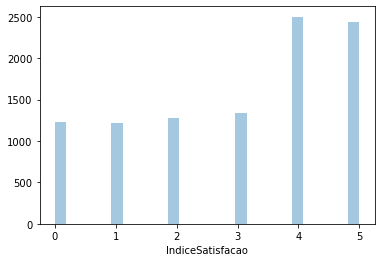

In [6]:
import seaborn as sns
sns.distplot(customer_data.IndiceSatisfacao, kde=False)

Now we can analyse how the numeric features correlate each other, `pandas` have a native method `corr()` that use `pearson` correlation by default (you can alter this behavior using the *method* parameter).

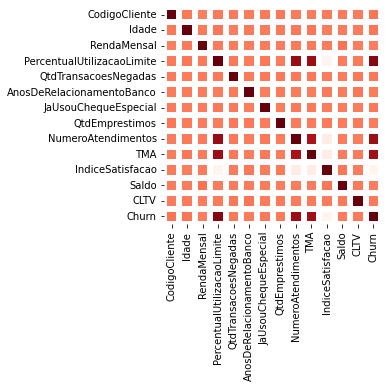

In [7]:
import matplotlib as plt

numeric_columns = []
for col in customer_data.columns:
    if(customer_data[col].dtypes!='object'):
        numeric_columns.append(col)
    
corr = customer_data[numeric_columns].corr()

ax1 = sns.heatmap(corr, cbar=0, linewidths=5, square=True, cmap='Reds')

## Preprocessing Data
Prior to training a model, check for missing values and split the data into training and validation sets.
In the last steps of this lab we already checked this point, so we cannot have any missing data

In [11]:
customer_data.isna().any()

CodigoCliente                 False
Titulo                        False
PrimeiroNome                  False
UltimoNome                    False
Idade                         False
Sexo                          False
Endereco                      False
Cidade                        False
UF                            False
UFCompleto                    False
CEP                           False
Pais                          False
PaisCompleto                  False
Email                         False
RendaMensal                   False
PercentualUtilizacaoLimite    False
QtdTransacoesNegadas          False
AnosDeRelacionamentoBanco     False
JaUsouChequeEspecial          False
QtdEmprestimos                False
NumeroAtendimentos            False
TMA                           False
IndiceSatisfacao              False
Saldo                         False
CLTV                          False
CanalPref                     False
Churn                         False
dtype: bool

 Remove missing values

In [12]:
customer_data = customer_data.dropna(axis=0)

In [13]:
customer_data.isna().any()

CodigoCliente                 False
Titulo                        False
PrimeiroNome                  False
UltimoNome                    False
Idade                         False
Sexo                          False
Endereco                      False
Cidade                        False
UF                            False
UFCompleto                    False
CEP                           False
Pais                          False
PaisCompleto                  False
Email                         False
RendaMensal                   False
PercentualUtilizacaoLimite    False
QtdTransacoesNegadas          False
AnosDeRelacionamentoBanco     False
JaUsouChequeEspecial          False
QtdEmprestimos                False
NumeroAtendimentos            False
TMA                           False
IndiceSatisfacao              False
Saldo                         False
CLTV                          False
CanalPref                     False
Churn                         False
dtype: bool

Indeed there is no missing data

## Train the model

First of all let's split train and test data

In [14]:
from sklearn.model_selection import train_test_split
SEED = 2020

train, test = train_test_split(customer_data, random_state=SEED, test_size=0.33)

In [15]:
train.head(1)

,CodigoCliente,Titulo,PrimeiroNome,UltimoNome,Idade,Sexo,Endereco,Cidade,UF,UFCompleto,...,AnosDeRelacionamentoBanco,JaUsouChequeEspecial,QtdEmprestimos,NumeroAtendimentos,TMA,IndiceSatisfacao,Saldo,CLTV,CanalPref,Churn
3782,3773.0,Sr.,Ryan,Goncalves,37.0,Masculino,Rua Caetano Sampieri 554,Bauru,SP,São Paulo,...,18.0,1.0,3.0,49.0,95.0,0.0,9681.0,86.0,Email,1.0


In [16]:
TARGET_COLUMN = 'Churn'
drop_columns = [TARGET_COLUMN, 'CodigoCliente'] 

X_train = train[numeric_columns].drop(drop_columns, axis=1)
X_test = test[numeric_columns].drop(drop_columns, axis=1)

y_train = train[TARGET_COLUMN]
y_test = test[TARGET_COLUMN]

## Building a Baseline Model
This task seems well suited to a random forest classifier, since the output is binary and there may be interactions between multiple variables.

The following code builds a simple classifier using scikit-learn.

In [17]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier

n_estimators = 3

model = RandomForestClassifier(n_estimators=n_estimators, random_state=np.random.RandomState(SEED))
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=3,
                       n_jobs=None, oob_score=False,
                       random_state=RandomState(MT19937) at 0x7F6EE3740258,
                       verbose=0, warm_start=False)

In [18]:
# predict_proba returns [prob_negative, prob_positive], so slice the output with [:, 1]
predictions_test = model.predict_proba(X_test)[:,1]

In [19]:
y_pred = model.predict(X_test)

#### Model Evaluation

Get False and True Positive rate

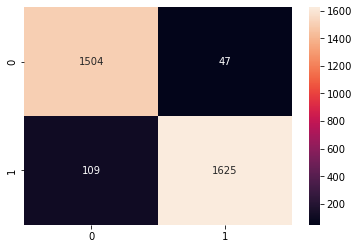

In [20]:
from sklearn.metrics import confusion_matrix
  
c_matrix_log = confusion_matrix(
  y_test, y_pred, labels=[0, 1])
sns.heatmap(
    c_matrix_log, annot=True, fmt="d")

In [21]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

print('Results: ',
          str(model).split('(')[0], '\nPrecisão: {0:.3}'.format(
              precision_score(y_test, y_pred)), '\nRecall: {0:.3f}'.format(
                  recall_score(y_test, y_pred)), '\nAUC: {0:.3f}'.format(
                      roc_auc_score(y_test, y_pred)),
          '\nAcurácia: {0:.3f}'.format(accuracy_score(y_test, y_pred)), '\n')

Results:  RandomForestClassifier 
Precisão: 0.972 
Recall: 0.937 
AUC: 0.953 
Acurácia: 0.953 



Plot ROC Curve

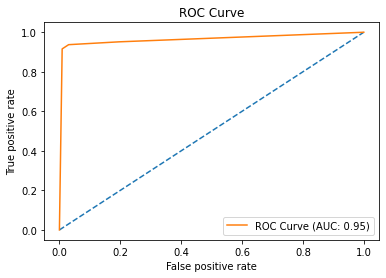

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fpr_rf, tpr_rf, _ = roc_curve(y_test, predictions_test)

plt.figure(1)
plt.plot([0, 1], [0, 1], '--')
plt.plot(fpr_rf, tpr_rf, label = 'ROC Curve (AUC: {0:.2f})'.format(
                      roc_auc_score(y_test, y_pred)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

Seems to be a good model to begin. 😃

But let's try to make some improvements ...

## XGBoost Model

In [44]:
import xgboost as xgb
import warnings

warnings.filterwarnings('ignore')

train = xgb.DMatrix(data=X_train, label=y_train)
test = xgb.DMatrix(data=X_test, label=y_test)

params = {'early_stopping_rounds': 50, 
          'learning_rate': 0.2260, 
          'max_depth': 64, 
          'maximize': False, 
          'min_child_weight': 19.22, 
          'num_boost_round': 1000, 
          'reg_alpha': 0.01, 
          'reg_lambda': 0.348, 
          'objective': 'binary:hinge',
          'seed': SEED}

# Pass in the test set so xgb can track an evaluation metric. XGBoost terminates training when the evaluation metric
# is no longer improving.
booster = xgb.train(params=params, dtrain=train, num_boost_round=1000,\
                    evals=[(test, "test")], early_stopping_rounds=50, verbose_eval=False)

predictions_test = booster.predict(test)
auc_score = roc_auc_score(y_test, predictions_test)
print(f'auc-score: {round(auc_score, 4)}')

auc-score: 0.9609
